In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [30]:
# import data from CSVs 
yelpparsed=pd.read_csv('../data/yelpdata.csv')
foursquareparsed=pd.read_csv('../data/foursqdata.csv')
citybikedata=pd.read_csv('../data/bikedata.csv')

In [36]:
# Rename for join
citybikedata.rename(columns={'name': 'station'}, inplace=True)

In [46]:
# Merge city bike data with Yelp parsed data
merged_df = pd.merge(
    citybikedata, 
    yelpparsed, 
    on=['station'], 
    how='inner', 
    suffixes=('city', 'yelp')
)

# Merge the previous result with Foursquare parsed data
final_df = pd.merge(
    merged_df, 
    foursquareparsed, 
    on=['station'], 
    how='inner', 
    suffixes=('', 'foursq')
)

# Rename columns for clarity
final_df = final_df.rename(
    columns={
        'distance': 'distanceyelp',
        'name': 'poiname',
        'rating': 'ratingyelp',
        'popularity': 'popularityfoursq'
    }
)

In [65]:
final_df.head()

,station,latitude,longitude,free_bikes,empty_slots,total_bike_cap,uid,renting,returning,last_updated,...,poiname,location.address,ratingyelp,categories,distancefoursq,namefoursq,location.addressfoursq,ratingfoursq,popularityfoursq,categoriesfoursq
0,Fairfax Dr & Wilson Blvd,38.885801,-77.097745,5,6,11,08251ded-1f3f-11e7-bf6b-3863bb334450,1,1,1729395530,...,The Liberty Tavern,3195 Wilson Blvd,3.8,bar,97,The Liberty Tavern,3195 Wilson Blvd,8.5,0.982389,bar
1,Fairfax Dr & Wilson Blvd,38.885801,-77.097745,5,6,11,08251ded-1f3f-11e7-bf6b-3863bb334450,1,1,1729395530,...,The Liberty Tavern,3195 Wilson Blvd,3.8,bar,240,Lyon Hall,3100 Washington Blvd,8.5,0.982187,bar
2,Fairfax Dr & Wilson Blvd,38.885801,-77.097745,5,6,11,08251ded-1f3f-11e7-bf6b-3863bb334450,1,1,1729395530,...,The Liberty Tavern,3195 Wilson Blvd,3.8,bar,131,The Lot,3217 10th St N,8.0,0.972111,bar
3,Fairfax Dr & Wilson Blvd,38.885801,-77.097745,5,6,11,08251ded-1f3f-11e7-bf6b-3863bb334450,1,1,1729395530,...,The Liberty Tavern,3195 Wilson Blvd,3.8,bar,62,O'Sullivan's Irish Pub,3207 Washington Blvd,7.5,0.980685,bar
4,Fairfax Dr & Wilson Blvd,38.885801,-77.097745,5,6,11,08251ded-1f3f-11e7-bf6b-3863bb334450,1,1,1729395530,...,The Liberty Tavern,3195 Wilson Blvd,3.8,bar,442,Screwtop Wine Bar,1025 N Fillmore St,8.5,0.965211,bar


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

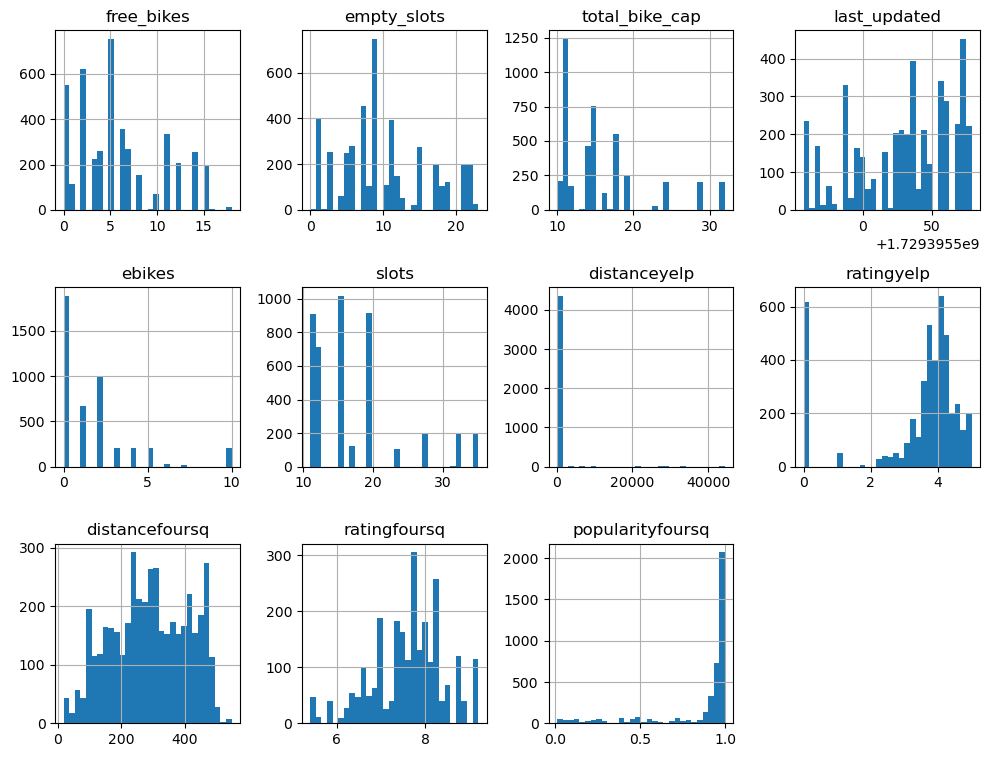

In [66]:
# Drop unnecessary columns for plotting
plot_columns = final_df.drop(
    ['latitude', 'longitude', 'renting', 'returning'], axis=1
)

# Create histograms for the remaining columns
plot_columns.hist(bins=30, figsize=(10, 10), layout=(4, 4))
plt.tight_layout()
plt.show()

Even if we wanted to replace popularity for ratings for Foursquare, they are mostly 9's with very little variation. The results are skewed significantly. 

In [67]:
# Create CSV for future steps
final_df.to_csv('../data/final_df.csv', index=False)

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [53]:
import sqlite3
from sqlite3 import Error as e

def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection successful")
    except Error as e:
        print(f'The error {e}')
    return connection



connection = create_connection('../data/db')

Connection successful


creating function to execute queries

In [54]:
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query successful")
    except Error as e:
        print(f"The error '{e}' occurred")

Creating and filling in stations table

In [55]:
create_stations_table = """
CREATE TABLE IF NOT EXISTS stations (
  id INTEGER PRIMARY KEY AUTOINCREMENT,
  name TEXT NOT NULL,
  latitude INTEGER,
  longitude INTEGER,
  free_bikes INTEGER,
  empty_slots INTEGER,
  total_bike_cap INTEGER
); """

execute_query(connection, create_stations_table)  


Query successful


In [56]:
cursor = connection.cursor()
for index, row in citybikedata.iterrows():
    create_station = """
    INSERT INTO 
        stations(name, latitude, longitude, free_bikes, empty_slots, total_bike_cap)
    VALUES
        (?, ?, ?, ?, ?, ?)
    """
    cursor.execute(create_station, (
        row['station'], 
        row['latitude'], 
        row['longitude'], 
        row['free_bikes'], 
        row['empty_slots'], 
        row['total_bike_cap']
    ))
connection.commit()


Creating and inserting yelp table

In [57]:
create_yelp_table = """
CREATE TABLE IF NOT EXISTS yelp (
  id INTEGER PRIMARY KEY AUTOINCREMENT,
  station TEXT NOT NULL,
  distance INTEGER,
  name TEXT NOT NULL,
  address TEXT,
  rating DECIMAL
); """

execute_query(connection, create_yelp_table)  


Query successful


In [58]:
for index, row in yelpparsed.iterrows():
    create_yelp = """
    INSERT INTO 
        yelp(station, distance, name, address, rating)
    VALUES
        (?, ?, ?, ?, ?)
    """
    cursor.execute(create_yelp, (
        row['station'], 
        row['distance'], 
        row['name'], 
        row['location.address'], 
        row['rating']
    ))
connection.commit()


Creating and filling Foursquare table

In [59]:
create_foursq_table = """
CREATE TABLE IF NOT EXISTS foursq (
  id INTEGER PRIMARY KEY AUTOINCREMENT,
  station TEXT NOT NULL,
  distance INTEGER,
  name TEXT NOT NULL,
  address TEXT,
  rating DECIMAL,
  popularity DECIMAL,
  categories TEXT
); """

execute_query(connection, create_foursq_table)  


Query successful


In [60]:
for index, row in foursquareparsed.iterrows():
    create_foursq = """
    INSERT INTO 
        foursq(station, distance, name, address, rating, popularity, categories)
    VALUES
        (?, ?, ?, ?, ?, ?, ?)
    """
    cursor.execute(create_foursq, (
        row['station'], 
        row['distance'], 
        row['name'], 
        row['location.address'], 
        row['rating'],
        row['popularity'],
        row['categories']
    ))
connection.commit()


Look at the data before and after the join to validate your data.

In [61]:
def execute_read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")

In [62]:
query = "SELECT * FROM foursq"
execute_read_query(connection, query)

[(1,
  'Fairfax Dr & Wilson Blvd',
  97,
  'The Liberty Tavern',
  '3195 Wilson Blvd',
  8.5,
  0.982388775009383,
  'bar'),
 (2,
  'Fairfax Dr & Wilson Blvd',
  240,
  'Lyon Hall',
  '3100 Washington Blvd',
  8.5,
  0.9821866789849004,
  'bar'),
 (3,
  'Fairfax Dr & Wilson Blvd',
  131,
  'The Lot',
  '3217 10th St N',
  8,
  0.9721107486214164,
  'bar'),
 (4,
  'Fairfax Dr & Wilson Blvd',
  62,
  "O'Sullivan's Irish Pub",
  '3207 Washington Blvd',
  7.5,
  0.980685394231602,
  'bar'),
 (5,
  'Fairfax Dr & Wilson Blvd',
  442,
  'Screwtop Wine Bar',
  '1025 N Fillmore St',
  8.5,
  0.9652106129283714,
  'bar'),
 (6,
  'Fairfax Dr & Wilson Blvd',
  200,
  'Pamplona',
  '3100 Clarendon Blvd',
  7.7,
  0.9549037156797644,
  'bar'),
 (7,
  'Fairfax Dr & Wilson Blvd',
  426,
  'The Board Room',
  '925 N Garfield St',
  8.2,
  0.9720241360394952,
  'bar'),
 (8,
  'Fairfax Dr & Wilson Blvd',
  157,
  'Don Tito',
  '3165 Wilson Blvd',
  7.3,
  0.9886248809076998,
  'bar'),
 (9,
  'Fairfax Dr 

I would execute a join statment to see the same results as a merged dataframe. The query would be as follows

In [63]:
query = """
SELECT s.station
FROM stations as s
JOIN yelp as y
ON s.station = y.station
"""